## 2.6. Probability and Statistics
https://d2l.ai/chapter_preliminaries/probability.html


In [190]:
# %matplotlib inline
import random
import torch
from IPython import display
from torch.distributions.multinomial import Multinomial
from d2l import torch as d2l

## 2.6.8. Exercises 7

7.1 Tính toán các xác suất theo yêu cầu của bải toán

In [191]:
def bayes_single_test(P_H1, false_pos, false_neg):
    """
    Tính xác suất P(H=1 | D=1) sau một test dương tính.
    """
    P_H0 = 1 - P_H1
    P_D_pos_given_H1 = 1 - false_neg
    P_D_pos_given_H0 = false_pos

    numerator = P_D_pos_given_H1 * P_H1
    denominator = numerator + P_D_pos_given_H0 * P_H0
    posterior = numerator / denominator
    return posterior


def bayes_double_test(P_H1, false_pos, false_neg, P_D1_D2_1_H0):
    """
    Tính xác suất P(H=1 | D1=1, D2=1) sau hai test dương tính.
    """
    P_H0 = 1 - P_H1
    P_D1_1_given_H1 = 1 - false_neg
    P_D2_1_given_H1 = 1 - false_neg

    # Vì D1 và D2 độc lập có điều kiện H=1
    P_D1_D2_1_H1 = P_D1_1_given_H1 * P_D2_1_given_H1

    numerator = P_D1_D2_1_H1 * P_H1
    denominator = numerator + P_D1_D2_1_H0 * P_H0
    posterior = numerator / denominator
    return posterior


def compute_joint_prob_H0(false_pos, P_D1_eq_D2_1_given_H0):
    """
    Tự động suy ra bảng xác suất joint P(D1, D2 | H=0) từ false positive rate và xác suất đồng thời D1=D2=1
    """
    p11 = P_D1_eq_D2_1_given_H0
    p10 = false_pos - p11
    p01 = false_pos - p11
    p00 = 1 - (p11 + p10 + p01)
    return {
        (0, 0): p00,
        (0, 1): p01,
        (1, 0): p10,
        (1, 1): p11
    }


# ======= INPUT TỪ ĐỀ BÀI BÀI TOÁN 7 =======
P_H1 = 0.0015  # Xác suất bệnh
false_positive = 0.1
false_negative = 0.01
P_D1_eq_D2_eq_1_given_H0 = 0.02

# ======= LỜI GIẢI CHO BÀI TOÁN 7  =======
# Câu 1: joint probability table
joint_table = compute_joint_prob_H0(false_positive, P_D1_eq_D2_eq_1_given_H0)
print("Joint probability table for D1, D2 given H=0:")
for (d1, d2), prob in joint_table.items():
    print(f"P(D1={d1}, D2={d2} | H=0) = {prob:.4f}")

# Câu 2: P(H=1 | D=1)
posterior_1 = bayes_single_test(P_H1, false_positive, false_negative)
print(f"\nP(H=1 | D=1) = {posterior_1:.4f} (~{posterior_1 * 100:.2f}%)")

# Câu 3: P(H=1 | D1=1, D2=1)
posterior_2 = bayes_double_test(P_H1, false_positive, false_negative, P_D1_eq_D2_eq_1_given_H0)
print(f"P(H=1 | D1=1, D2=1) = {posterior_2:.4f} (~{posterior_2 * 100:.2f}%)")


Joint probability table for D1, D2 given H=0:
P(D1=0, D2=0 | H=0) = 0.8200
P(D1=0, D2=1 | H=0) = 0.0800
P(D1=1, D2=0 | H=0) = 0.0800
P(D1=1, D2=1 | H=0) = 0.0200

P(H=1 | D=1) = 0.0147 (~1.47%)
P(H=1 | D1=1, D2=1) = 0.0686 (~6.86%)


## 7.2 Mô phỏng bằng biểu đồ Bar Chart để trực quan hóa hai xác suất

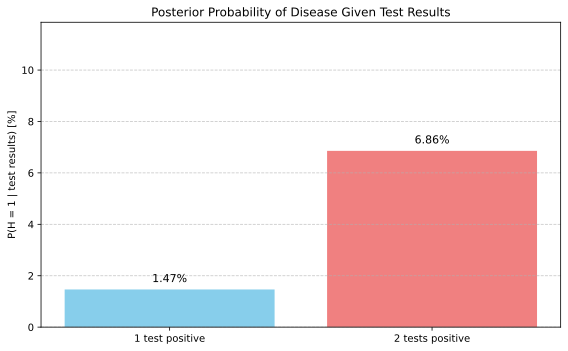

In [192]:
import matplotlib.pyplot as plt

# Dữ liệu để plot
labels = ['1 test positive', '2 tests positive']
values = [posterior_1, posterior_2]
percent_values = [v * 100 for v in values]

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, percent_values, color=['skyblue', 'lightcoral'])
plt.ylabel('P(H = 1 | test results) [%]')
plt.title('Posterior Probability of Disease Given Test Results')

# Ghi số trên đầu cột
for bar, value in zip(bars, percent_values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             value + 0.2,
             f'{value:.2f}%',
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, max(percent_values) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 7.3 Mô phỏng bài toán bằng thử nghiệm ngẫu nhiên (Monte Carlo)

In [193]:
import numpy as np

def monte_carlo_simulation(n_trials, P_H1, false_pos, false_neg, P_D1_D2_1_H0):
    """
    Mô phỏng Monte Carlo để ước lượng P(H=1 | D1=1, D2=1)
    """
    # Tạo mảng ngẫu nhiên xác định người bệnh (H=1) hay khỏe (H=0)
    H = np.random.rand(n_trials) < P_H1

    # Khởi tạo mảng lưu kết quả test D1 và D2
    D1 = np.zeros(n_trials, dtype=int)
    D2 = np.zeros(n_trials, dtype=int)

    # Với H = 1 (bệnh): D1, D2 độc lập, xác suất đúng dương = 1 - false_negative
    idx_H1 = np.where(H)[0]
    D1[idx_H1] = np.random.rand(len(idx_H1)) < (1 - false_neg)
    D2[idx_H1] = np.random.rand(len(idx_H1)) < (1 - false_neg)

    # Với H = 0 (khỏe): tạo D1, D2 có phụ thuộc để giữ đúng P(D1=1, D2=1 | H=0) = 0.02
    idx_H0 = np.where(~H)[0]
    for i in idx_H0:
        r = np.random.rand()
        if r < P_D1_D2_1_H0:
            D1[i] = 1
            D2[i] = 1
        elif r < P_D1_D2_1_H0 + (false_pos - P_D1_D2_1_H0):  # D1=1, D2=0
            D1[i] = 1
            D2[i] = 0
        elif r < P_D1_D2_1_H0 + 2 * (false_pos - P_D1_D2_1_H0):  # D1=0, D2=1
            D1[i] = 0
            D2[i] = 1
        else:
            D1[i] = 0
            D2[i] = 0

    # Đếm số trường hợp D1=1 và D2=1
    both_positive = (D1 == 1) & (D2 == 1)
    count_both_positive = np.sum(both_positive)
    count_H1_given_both_positive = np.sum(H[both_positive])

    # Tính xác suất hậu nghiệm
    posterior_estimate = count_H1_given_both_positive / count_both_positive
    return posterior_estimate


# ====== THÔNG SỐ ĐẦU VÀO ======
P_H1 = 0.0015
false_pos = 0.1
false_neg = 0.01
P_D1_D2_1_H0 = 0.02
n_simulations = 10**7  # 10 triệu thử nghiệm

# ====== CHẠY MÔ PHỎNG VÀ XUẤT KẾT QUẢ ======
posterior_mc = monte_carlo_simulation(n_simulations, P_H1, false_pos, false_neg, P_D1_D2_1_H0)

print(f"\nMonte Carlo estimate of P(H=1 | D1=1, D2=1): {posterior_mc:.4f} (~{posterior_mc * 100:.2f}%)")



Monte Carlo estimate of P(H=1 | D1=1, D2=1): 0.0694 (~6.94%)


## 2.6.8. Exercises 8

# 8.0. Lấy dữ liệu cổ phiếu Việt Nam

In [194]:
## Chọn 5 mã từ danh mục
#stock = vn3.Vnstock().stock(source='TCBS')
#stock.listing.all_symbols()
#import vnstock as vn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Đọc dữ liệu từ file CSV
df = pd.read_csv('vietnam_stock_prices_2023_2024.csv', index_col=0, parse_dates=True)

# Tính lợi suất hàng ngày (daily returns)
returns = df.pct_change().dropna()

# Tính kỳ vọng lợi suất trung bình và ma trận hiệp phương sai
mu = returns.mean().values
Sigma = returns.cov().values

# Số lượng tài sản
n = len(mu)

# Khởi tạo biến trọng số danh mục
w = cp.Variable(n)

# Bài toán Markowitz: tối ưu hóa tỷ lệ Sharpe (không có rủi ro)
risk_aversion = 1  # hệ số điều chỉnh giữa lợi nhuận và rủi ro

# Hàm mục tiêu: cực tiểu hóa rủi ro - tối đa hóa lợi nhuận
objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))

# Ràng buộc: tổng trọng số = 1 và mỗi trọng số không âm
constraints = [cp.sum(w) == 1, w >= 0]

# Giải bài toán tối ưu
prob = cp.Problem(objective, constraints)
prob.solve()

# Kết quả
optimal_weights = w.value
portfolio_return = mu @ optimal_weights
portfolio_risk = np.sqrt(optimal_weights.T @ Sigma @ optimal_weights)


## 8.1. Lợi nhuận kỳ vọng hàng năm của danh mục

In [195]:
# --- Tính lợi nhuận kỳ vọng của danh mục ---
# Lợi nhuận kỳ vọng hàng ngày đã có:
expected_return_daily = np.dot(mu, optimal_weights)

# Giả định có 252 ngày giao dịch/năm
expected_return_annual = expected_return_daily * 252

print(f"\nLợi suất kỳ vọng hàng ngày của danh mục: {expected_return_daily:.4%}")
print(f"Lợi suất kỳ vọng hàng năm của danh mục: {expected_return_annual:.2%}")




Lợi suất kỳ vọng hàng ngày của danh mục: 0.1783%
Lợi suất kỳ vọng hàng năm của danh mục: 44.94%


## 8.2. Tối đa hóa lợi nhuận danh mục đầu tư

In [196]:

# --- Tối đa hóa lợi nhuận danh mục đầu tư ---
# Khởi tạo biến trọng số mới
w_max_return = cp.Variable(n)

# Hàm mục tiêu: tối đa hóa lợi nhuận kỳ vọng
objective_max_return = cp.Maximize(mu @ w_max_return)

# Ràng buộc: tổng trọng số = 1, không bán khống
constraints_max_return = [cp.sum(w_max_return) == 1, w_max_return >= 0]

# Giải bài toán
prob_max_return = cp.Problem(objective_max_return, constraints_max_return)
prob_max_return.solve()

# Kết quả
weights_max_return = w_max_return.value
portfolio_return_max = mu @ weights_max_return
portfolio_risk_max = np.sqrt(weights_max_return.T @ Sigma @ weights_max_return)

print("\n Tối đa hóa lợi nhuận danh mục:")
for ticker, weight in zip(df.columns, weights_max_return):
    print(f"{ticker}: {weight:.2%}")

print(f"\n Lợi suất kỳ vọng danh mục tối đa lợi nhuận: {portfolio_return_max:.2%}")
print(f" Rủi ro tương ứng (độ lệch chuẩn): {portfolio_risk_max:.2%}")



 Tối đa hóa lợi nhuận danh mục:
STOCK001: 0.00%
STOCK002: 100.00%
STOCK003: 0.00%
STOCK004: 0.00%
STOCK005: 0.00%
STOCK006: 0.00%
STOCK007: 0.00%
STOCK008: 0.00%
STOCK009: 0.00%
STOCK010: 0.00%
STOCK011: 0.00%
STOCK012: 0.00%
STOCK013: 0.00%
STOCK014: 0.00%
STOCK015: 0.00%
STOCK016: 0.00%
STOCK017: 0.00%
STOCK018: 0.00%
STOCK019: 0.00%
STOCK020: 0.00%
STOCK021: 0.00%
STOCK022: 0.00%
STOCK023: 0.00%
STOCK024: 0.00%
STOCK025: 0.00%
STOCK026: 0.00%
STOCK027: 0.00%
STOCK028: 0.00%
STOCK029: 0.00%
STOCK030: 0.00%
STOCK031: 0.00%
STOCK032: 0.00%
STOCK033: 0.00%
STOCK034: 0.00%
STOCK035: 0.00%
STOCK036: 0.00%
STOCK037: 0.00%
STOCK038: 0.00%
STOCK039: 0.00%
STOCK040: 0.00%
STOCK041: 0.00%
STOCK042: 0.00%
STOCK043: 0.00%
STOCK044: 0.00%
STOCK045: 0.00%
STOCK046: 0.00%
STOCK047: 0.00%
STOCK048: 0.00%
STOCK049: 0.00%
STOCK050: 0.00%

 Lợi suất kỳ vọng danh mục tối đa lợi nhuận: 0.19%
 Rủi ro tương ứng (độ lệch chuẩn): 3.32%


## 8.3. Tính toán phương sai của danh mục đầu tư

In [197]:
# Tính phương sai danh mục Markowitz
portfolio_variance = optimal_weights.T @ Sigma @ optimal_weights
print(f"\nPhương sai danh mục Markowitz: {portfolio_variance:.6f}")



Phương sai danh mục Markowitz: 0.000119


## 8.4. Xây dựng bài toán tối ưu để tối đa hóa lợi nhuận trong khi giữ phương sai ở một ngưỡng nhất định.
(Tối đa hóa lợi nhuận với ràng buộc phương sai)

In [198]:

# Cài đặt ngưỡng phương sai cho phép: 0.0004 tương ứng độ lệch chuẩn ≈ 2%
target_variance = 0.0004  # Bạn có thể thay đổi giá trị này

# Biến trọng số
w_risk_constrained = cp.Variable(n)

# Hàm mục tiêu: tối đa hóa lợi nhuận kỳ vọng
objective_risk_constrained = cp.Maximize(mu @ w_risk_constrained)

# Ràng buộc:
constraints_risk_constrained = [
    cp.sum(w_risk_constrained) == 1,          # Tổng trọng số bằng 1
    w_risk_constrained >= 0,                  # Không bán khống
    cp.quad_form(w_risk_constrained, Sigma) <= target_variance  # Phương sai không vượt ngưỡng
]

# Giải bài toán
prob_risk_constrained = cp.Problem(objective_risk_constrained, constraints_risk_constrained)
prob_risk_constrained.solve()

# Kết quả
weights_risk_constrained = w_risk_constrained.value
portfolio_return_risk_constrained = mu @ weights_risk_constrained
portfolio_variance_risk_constrained = weights_risk_constrained.T @ Sigma @ weights_risk_constrained

print("\nDanh mục tối ưu với ràng buộc phương sai:")
for ticker, weight in zip(df.columns, weights_risk_constrained):
    print(f"{ticker}: {weight:.2%}")

print(f"\nLợi suất kỳ vọng: {portfolio_return_risk_constrained:.2%}")
print(f"Phương sai danh mục: {portfolio_variance_risk_constrained:.6f}")
print(f"Độ lệch chuẩn: {np.sqrt(portfolio_variance_risk_constrained):.2%}")



Danh mục tối ưu với ràng buộc phương sai:
STOCK001: 0.00%
STOCK002: 52.89%
STOCK003: 0.00%
STOCK004: 0.00%
STOCK005: 0.00%
STOCK006: 0.00%
STOCK007: 0.00%
STOCK008: 0.00%
STOCK009: 0.00%
STOCK010: 0.00%
STOCK011: 0.00%
STOCK012: 1.09%
STOCK013: 0.00%
STOCK014: 0.00%
STOCK015: 0.00%
STOCK016: 0.00%
STOCK017: 0.00%
STOCK018: 0.00%
STOCK019: 0.00%
STOCK020: 0.00%
STOCK021: 0.00%
STOCK022: 0.00%
STOCK023: 0.00%
STOCK024: 0.00%
STOCK025: 0.00%
STOCK026: 0.00%
STOCK027: 0.00%
STOCK028: 0.00%
STOCK029: 0.00%
STOCK030: 0.00%
STOCK031: 0.00%
STOCK032: 0.00%
STOCK033: 0.00%
STOCK034: 44.59%
STOCK035: 0.00%
STOCK036: 0.00%
STOCK037: 0.00%
STOCK038: 0.00%
STOCK039: 0.00%
STOCK040: 0.00%
STOCK041: 0.00%
STOCK042: 0.00%
STOCK043: 0.00%
STOCK044: 0.00%
STOCK045: 0.00%
STOCK046: 0.00%
STOCK047: 0.00%
STOCK048: 0.00%
STOCK049: 0.00%
STOCK050: 1.43%

Lợi suất kỳ vọng: 0.18%
Phương sai danh mục: 0.000400
Độ lệch chuẩn: 2.00%


## 8.5. Vẽ danh mục đầu tư tối ưu

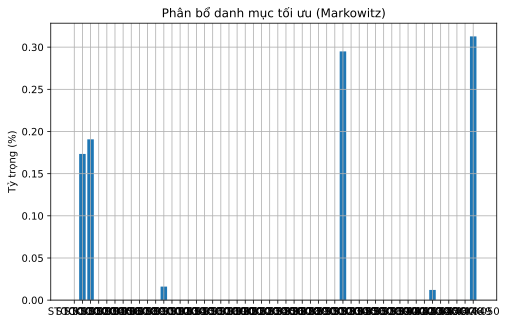

In [199]:
# Vẽ biểu đồ phân bổ danh mục
plt.figure(figsize=(8, 5))
plt.bar(df.columns, optimal_weights)
plt.title("Phân bổ danh mục tối ưu (Markowitz)")
plt.ylabel("Tỷ trọng (%)")
plt.grid(True)
plt.show()


## Bài toán nâng cao 1 (NC1)
Bài nâng cao dựa trên bài toán xác suất xét nghiệm y tế ở EXCERCISE 7, kết hợp thêm các yếu tố thực tế như chi phí xét nghiệm, tối ưu quyết định, và mở rộng thành bài toán ra quyết định dựa trên Bayesian decision theory. 

## NC1.1. Tính xác suất hậu nghiệm

In [200]:
def bayes_posterior(s, k, P_H1=0.0015, tp=0.99, fp=0.10):
    """
    s: số lần dương tính
    k: tổng số test đã làm
    """
    fn = 1 - tp
    tn = 1 - fp
    P_H0 = 1 - P_H1

    # Likelihood
    L1 = (tp**s) * (fn**(k - s))
    L0 = (fp**s) * (tn**(k - s))

    numerator = L1 * P_H1
    denominator = numerator + L0 * P_H0
    return numerator / denominator


## NC1.2. Tính chi phí kỳ vọng của các hành động và
## NC1.3. Xây dựng thuật toán chọn hành động tối ưu (cây quyết định)

In [201]:
from functools import lru_cache

@lru_cache(maxsize=None)
def expected_cost(s, k, max_tests=3):
    if k == max_tests:
        # Đã test đủ, chọn giữa A và B
        p = bayes_posterior(s, k)
        cost_A = (1 - p) * 500 + k * 50
        cost_B = p * 10000 + k * 50
        return min(cost_A, cost_B)

    # Nếu điều trị ngay
    p = bayes_posterior(s, k)
    cost_A = (1 - p) * 500 + k * 50
    cost_B = p * 10000 + k * 50

    # Nếu test thêm 1 lần
    # Kỳ vọng theo kết quả test tiếp theo (dương hoặc âm)
    p_next_pos = p * 0.99 + (1 - p) * 0.10
    p_next_neg = 1 - p_next_pos

    cost_next_pos = expected_cost(s + 1, k + 1)
    cost_next_neg = expected_cost(s, k + 1)

    cost_C = k * 50 + 50 + (p_next_pos * cost_next_pos + p_next_neg * cost_next_neg)

    return min(cost_A, cost_B, cost_C)


## ## NC1.4. Mô phỏng, trực quan hóa cây quyết định

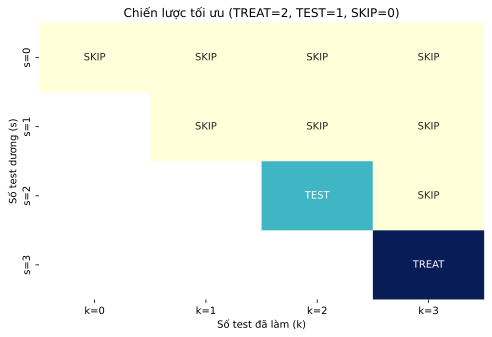

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache

# Các thông số
P_H1 = 0.0015
TPR = 0.99
FPR = 0.10
FNR = 1 - TPR
TNR = 1 - FPR
COST_TEST = 50
COST_TREAT_HEALTHY = 500
COST_SKIP_SICK = 10000

# Hàm Bayes
def bayes_posterior(s, k, P_H1=P_H1, tp=TPR, fp=FPR):
    fn = 1 - tp
    tn = 1 - fp
    P_H0 = 1 - P_H1
    L1 = (tp**s) * (fn**(k - s))
    L0 = (fp**s) * (tn**(k - s))
    numerator = L1 * P_H1
    denominator = numerator + L0 * P_H0
    return numerator / denominator if denominator != 0 else 0

@lru_cache(maxsize=None)
def optimal_strategy(s, k, max_tests=3):
    p = bayes_posterior(s, k)
    cost_A = (1 - p) * COST_TREAT_HEALTHY + k * COST_TEST
    cost_B = p * COST_SKIP_SICK + k * COST_TEST
    if k >= max_tests:
        return min((cost_A, 'TREAT'), (cost_B, 'SKIP'), key=lambda x: x[0])
    p_pos = p * TPR + (1 - p) * FPR
    p_neg = 1 - p_pos
    cost_pos = optimal_strategy(s + 1, k + 1)[0]
    cost_neg = optimal_strategy(s, k + 1)[0]
    cost_C = k * COST_TEST + COST_TEST + (p_pos * cost_pos + p_neg * cost_neg)
    return min((cost_A, 'TREAT'), (cost_B, 'SKIP'), (cost_C, 'TEST'), key=lambda x: x[0])

# Tạo ma trận chiến lược (s, k)
max_tests = 3
strategy_matrix = np.full((max_tests + 1, max_tests + 1), '', dtype='<U10')

for k in range(max_tests + 1):
    for s in range(k + 1):  # s ≤ k
        strategy_matrix[s, k] = optimal_strategy(s, k)[1]

# Ánh xạ ký hiệu sang số
strategy_to_num = {'TREAT': 2, 'TEST': 1, 'SKIP': 0}

# Chuyển thành DataFrame để vẽ
df = pd.DataFrame(strategy_matrix, index=[f"s={i}" for i in range(max_tests + 1)],
                  columns=[f"k={i}" for i in range(max_tests + 1)])

df_num = df.applymap(lambda x: strategy_to_num.get(x, np.nan))  # né lỗi KeyError

# Vẽ heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_num, annot=df, fmt="", cmap="YlGnBu", cbar=False)
plt.title("Chiến lược tối ưu (TREAT=2, TEST=1, SKIP=0)")
plt.xlabel("Số test đã làm (k)")
plt.ylabel("Số test dương (s)")
plt.show()


## NC1.5. Mô phỏng bằng Monte Carlo với chiến lược này trên 1 triệu bệnh nhân để tính chi phí trung bình mà bệnh viện phải chi trả

In [203]:
import numpy as np

# Tham số
NUM_PATIENTS = 1_000_000
np.random.seed(42)  # để kết quả ổn định

# Lấy ma trận chiến lược đã tính ở bước trước: strategy_matrix[s, k]
# Đảm bảo bạn đã chạy đoạn mã trước đó để có biến `strategy_matrix`

# Hàm mô phỏng chi phí cho một bệnh nhân
def simulate_patient(strategy_matrix, max_tests=3):
    is_sick = np.random.rand() < P_H1
    k = 0  # số lần test đã làm
    s = 0  # số test ra dương tính
    total_cost = 0

    while True:
        action = strategy_matrix[s, k]

        if action == 'TREAT':
            total_cost += COST_TREAT_HEALTHY if not is_sick else 0
            total_cost += k * COST_TEST
            return total_cost
        elif action == 'SKIP':
            total_cost += COST_SKIP_SICK if is_sick else 0
            total_cost += k * COST_TEST
            return total_cost
        elif action == 'TEST':
            test_result = None
            if is_sick:
                test_result = np.random.rand() < TPR
            else:
                test_result = np.random.rand() < FPR
            k += 1
            if test_result:
                s += 1
            total_cost += COST_TEST
        else:
            raise ValueError(f"Unknown action: {action}")

# Mô phỏng nhiều bệnh nhân
total_cost = 0
for _ in range(NUM_PATIENTS):
    total_cost += simulate_patient(strategy_matrix)

average_cost = total_cost / NUM_PATIENTS
print(f"Chi phí trung bình mỗi bệnh nhân mà bệnh viện phải chi trả: {average_cost:.2f}$")


Chi phí trung bình mỗi bệnh nhân mà bệnh viện phải chi trả: 15.07$
